In [14]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs
from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance

### Loading Data and Subsetting for Ease of Calculation
- Subsetting years, and geographic bounds due to runtime constraints

In [22]:
# monthly ssh data
ds = xr.open_dataset('odiv2_zos_2005_2014.nc')
ds = ds.sel(time=slice('2011', '2013')).zos
coarsen_factor_lon = 20
coarsen_factor_lat = 20

# Coarsen the data by the specified factors
ds = ds.coarsen(xh=coarsen_factor_lon, yh=coarsen_factor_lat).mean()
xh_min = -300
xh_max = 60
yh_min = -60
yh_max = 60

subset = ds.sel(xh=slice(xh_min, xh_max), yh=slice(yh_min, yh_max))

ds_subset = subset.to_dataframe()
#ds = ds.zos
ds_dataframe_nonnan = ds_subset.dropna()

# this allows me to fill an array of nans near the end of my code

### Getting Dictionary then Keys 

In [23]:
# grouped by unique keys without nan muddling this. This is useful as we can then index the ds_dataframe_nonan
grouped_df = ds_dataframe_nonnan.groupby(['xh', 'yh'])
grouped_by_xh_yh = grouped_df.groups
keys_for_indexing = list(grouped_by_xh_yh.keys())

### Comparison Matrix (distance matrix)

In [25]:
n = len(grouped_by_xh_yh)
comparison_matrix = np.zeros((n, n), dtype=float)

val_count = 0
print(len(grouped_by_xh_yh))

time = 0
for i, indv_index1 in enumerate(keys_for_indexing):
    # this is giving some certain locations lon and lat which is useful as this can be inputted into the 
    # location finder to get the time series for every multi-index available except
    
    single_yh1, single_xh1 = indv_index1[1], indv_index1[0]
    ds_single_timeseries = ds_dataframe_nonnan.loc[(ds_dataframe_nonnan.index.get_level_values('xh') == single_xh1) 
                        & (ds_dataframe_nonnan.index.get_level_values('yh') == single_yh1)]

    for j, indv_index2 in enumerate(keys_for_indexing):        
        
        single_yh2, single_xh2 = indv_index2[1], indv_index2[0]
        
        ds_single_timeseries2 = ds_dataframe_nonnan.loc[(ds_dataframe_nonnan.index.get_level_values('xh') == single_xh2) 
                            & (ds_dataframe_nonnan.index.get_level_values('yh') == single_yh2)]
        
        # now we do a calculation to find 'distance'
        geo_distance = -distance.distance((single_yh1, single_xh1), (single_yh2, single_xh2)).km/(2*46.51927**2)
        time_series_correlation = np.corrcoef(ds_single_timeseries.zos.values, ds_single_timeseries2.zos.values)[0, 1]
        comparison_matrix[i][j] = 1-np.exp(geo_distance)*time_series_correlation
        
    print(i)


1754
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

### Array to be filled

In [26]:
nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                                dims=nan_dataset_to_fill['zos'].dims)

nan_dataset_to_fill = nan_dataset_to_fill.drop('time')
nan_dataset_to_fill = nan_dataset_to_fill.zos[0]

### Reloading the Saved Comparison Matrix
- can skip to here if you have the comparison matrix saved as a file 

In [107]:
file_path = 'comparison_matrix_saved.txt'
comparison_matrix = np.loadtxt(file_path)

### Inputting into Agglomerative Hierarchical Clustering Function

In [109]:
num_clusters = 4
#num_connections = 45
linkage='average'

#knn_graph = kneighbors_graph(comparison_matrix, num_connections, include_self=False)

clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage)
# Fit the clustering model with the distance matrix
#knn_graph = knn_graph.toarray()
clustering.fit(comparison_matrix)

# Retrieve the cluster labels assigned to each point
cluster_labels = clustering.labels_

# Print the cluster labels
print(cluster_labels)

C:\Users\13107\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


[1 1 1 ... 0 1 1]


### Making it plotable

In [110]:
unique_labels = np.unique(cluster_labels)
color_value = 0
list_to_array_slicing = np.array(keys_for_indexing)

for label in unique_labels:
    cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
    # in the code below when we index using 0 and 1 that is the array of the xh and yh coords. We must now put these into an xarray dataset.
    group_xh = list_to_array_slicing[cluster_points, 0]
    group_yh = list_to_array_slicing[cluster_points, 1]
    
    for point_iterator in range(len(group_yh)):
        nan_dataset_to_fill.loc[{'xh': group_xh[point_iterator], 'yh': group_yh[point_iterator]}] = color_value
    
    color_value += 1
    

### Plotting and checking bounds 

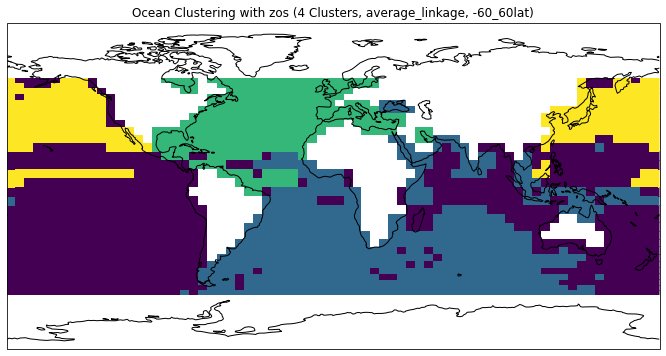

In [111]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})

# Plot the ocean boundaries using xarray.Dataset.plot()
nan_dataset_to_fill.plot(ax=ax, transform=projection, cmap='viridis', add_colorbar=False)
ax.set_title(f'Ocean Clustering with zos ({num_clusters} Clusters, {linkage}_linkage, {yh_min}_{yh_max}lat)')
ax.set_extent([-180, 180, -90, 90], crs=projection)
ax.coastlines()
plt.savefig(f'clustering_6_11/{linkage}_linkage_{num_clusters}_clusters_{yh_min}_{yh_max}lat')

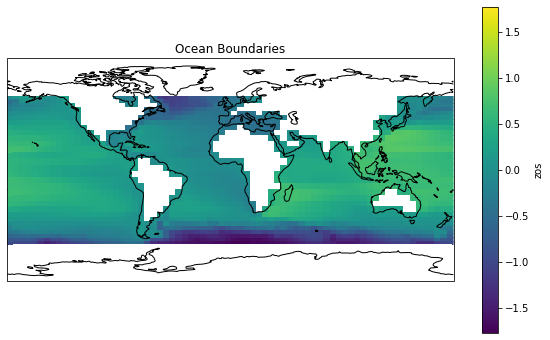

In [490]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

subset.mean(dim='time').plot(ax=ax, transform=projection, cmap='viridis', add_colorbar=True)
ax.set_title('Ocean Boundaries')
ax.set_extent([-180, 180, -90, 90], crs=projection)
ax.coastlines()